006067
6
[0.8037741288192363, 0.7051323404003773, 0.7744641061332966, 0.8320417253713213, 0.7228537982431756]
[0.8037741288192363, 0.7051323404003773, 0.3194236410927104, 0.7744641061332966, 0.8320417253713213, 0.7228537982431756]


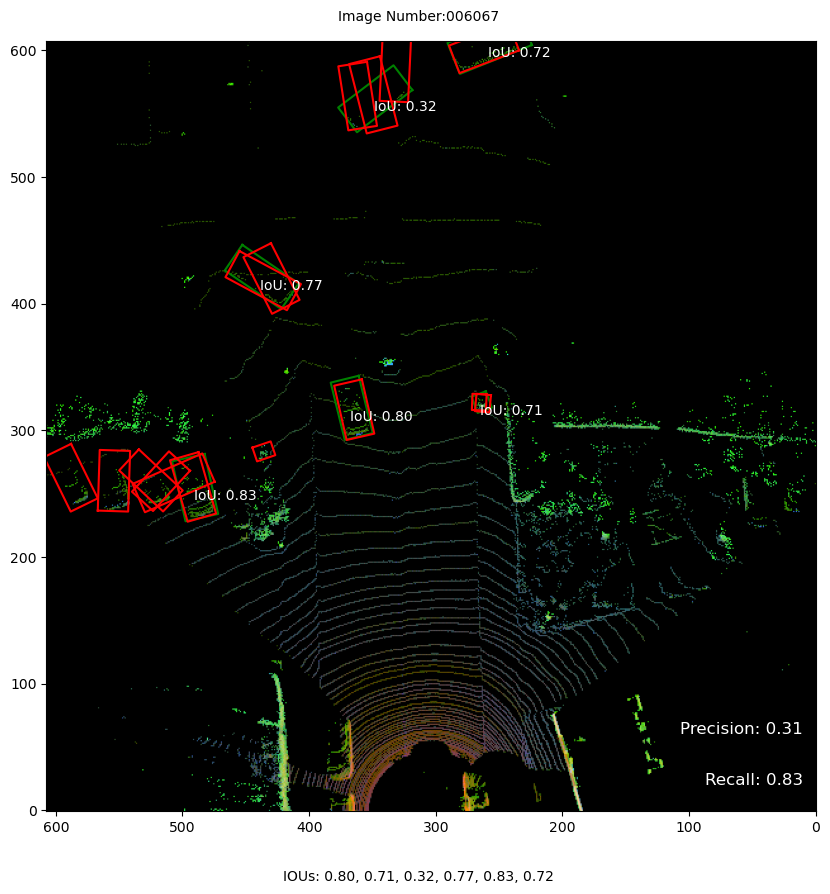

In [ ]:
import numpy as np
import cv2
from shapely.geometry import box
from shapely.affinity import rotate
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

root =  "C:/Users/nightfury/Desktop/PYTHON BASICS/KittyDatasets/KITTI_Selection"

dir_bev = f"{root}/bev/"
dir_predictions = f"{root}/predictions/"
dir_labels = f"{root}/labels/"
dir_img = f"{root}/images/"

idxs = ['006067', '006059', '006310', '006227', '006121', '006315', '006211',
        '006042', '006130', '006374', '006037', '006097', '006048', '006206',
        '006253', '006098', '006291', '006312', '006329', '006054']

 #The i number is acessed from the above list and begins from 1)
i=0

image=idxs[i]
print(image)

bev = cv2.imread(f"{dir_bev}/{idxs[i]}.png")
predictions = np.loadtxt(f"{dir_predictions}/{idxs[i]}.csv", delimiter = ",")
labels = np.loadtxt(f"{dir_labels}/{idxs[i]}.csv", delimiter = ",")
class_label, x, y, w, l, im, re = labels[0]

#Calcuation of x1,y1,x2,y2 co-ordinates for labels
#labels[:,1]-x-centre co-ordinate
#labels[:,3] width of BB
#labels[:,2]-y-centre co-ordinate
#labels[:,4]Height of BB
x1=labels[:,1]-(labels[:,3]/2)
y1=labels[:,2]-(labels[:,4]/2)
x2=labels[:,3]+x1
y2=labels[:,4]+y1
boxA=(x1,y1,x2,y2) #list boxA
img=labels[:,5]
real=labels[:,6]
complex_numbers = np.vectorize(complex)(real, img)
thetas = np.angle(complex_numbers)
theta_degrees = np.degrees(thetas)
print(len(labels))

#x, y, w, l, im, re, object_conf, class_score, class_pred = predictions[0]

#Calcuation of x1,y1,x2,y2 co-ordinates for Predections
#Predections[:,0]-x-centre co-ordinate
#Predections[:,2] width of BB
#Predections[:,1]-y-centre co-ordinate
#Predections[:,3]Height of BB
x11=predictions[:,0]-(predictions[:,2]/2) #xmin
y11=predictions[:,1]-(predictions[:,3]/2)#ymin
x22=predictions[:,2]+x11 #xmax
y22=predictions[:,3]+y11 #ymax
boxB=(x11,y11,x22,y22) #list boxB
img1=predictions[:,4]
real1=predictions[:,5]
complex_numbers1 = np.vectorize(complex)(real1, img1)
thetas1 = np.angle(complex_numbers1)
theta_degrees1 = np.degrees(thetas1)

#plotting 
plt.figure(figsize=(10, 10))
plt.imshow(bev[:, :, [2, 1, 0]])

x_limits = plt.xlim()
y_limits = plt.ylim()
plt.xlim(x_limits[1], x_limits[0])
plt.ylim(y_limits[1], y_limits[0])

rotated_boxes = [rotate(box(x1[i], y1[i], x2[i], y2[i]), theta_degrees[i], origin='centroid') for i in range(len(labels))]

# Plot rotated bounding boxes
for rotated_box in rotated_boxes:
    x, y = rotated_box.exterior.xy
    plt.plot(x, y, 'g-')

rotated_boxes2 = [rotate(box(x11[i], y11[i], x22[i], y22[i]), theta_degrees1[i], origin='centroid') for i in range(len(predictions))]
for rotated_box in rotated_boxes2:
    x, y = rotated_box.exterior.xy
    plt.plot(x, y, 'r-')

xc=labels[:,1]
yc=labels[:,2]
# Plot rotated bounding boxes


 #Defining function to calculate IOU:
def calculate_iou(polygon1, polygon2):
# Create Shapely Polygon objects
    poly1 = Polygon(polygon1)
    poly2 = Polygon(polygon2)

    # Calculate intersection area
    intersection_area = poly1.intersection(poly2).area

    # Calculate union area
    union_area = poly1.union(poly2).area

    # Calculate IoU
    iou = intersection_area / union_area 
    

    return iou

ious = np.zeros((len(rotated_boxes), len(rotated_boxes2)))
iou_per_label=[]
iou_great_0=[]
max_iou_values = [] 
True_positive= [] 
for i in range(len(rotated_boxes)):
    iou_per_label_for_i = [] 
    for j in range(len(rotated_boxes2)):
        coords_box1 = rotated_boxes[i]
        coords_box2 = rotated_boxes2[j]
        ious = calculate_iou(coords_box1, coords_box2)
        iou_per_label_for_i.append(ious)

    iou_per_label.append(iou_per_label_for_i)  
    iou_great_0_for_i = [iou for iou in iou_per_label_for_i if iou > 0.0] # Check for IoU values greater than 0.0 for each j
    iou_great_0.append(iou_great_0_for_i)
    max_iou_for_i = max(iou_great_0_for_i, default=0)
    max_iou_values.append(max_iou_for_i)
   

mask = [value > 0.5 for value in max_iou_values]

# Filter values greater than 0.5 and append to True_positive list
true_positive_values = [value for value, is_positive in zip(max_iou_values, mask) if is_positive]
True_positive.extend(true_positive_values)
    
print(True_positive)
print(  max_iou_values)
for i in range(len(labels)):
    plt.text(xc[i]+1,yc[i]-10, f'IoU: { max_iou_values[i]:.2f}', color='white')
          
#Calculation of Precision.
TP=len(True_positive)
FP=len(predictions)-len( True_positive)
PR=(TP/(TP+FP))
FN=(len(labels)-TP)
    #Calculation of Recall
RC=(TP/(TP+FN))

plt.text(10, 60, f'Precision: {PR:.2f}',  horizontalalignment='right', fontsize=12, color='white') 
plt.text(10, 20, f'Recall: {RC:.2f}',  horizontalalignment='right', fontsize=12, color='white')    
plt.figtext(0.5, 0.90,f'Image Number:{ image}', wrap=True, horizontalalignment='center', fontsize=10)
iou_str = ', '.join([f'{iou:.2f}' for iou in max_iou_values])
plt.figtext(0.5, 0.04, f'IOUs: {iou_str}', wrap=True, horizontalalignment='center', fontsize=10)
              
plt.show()